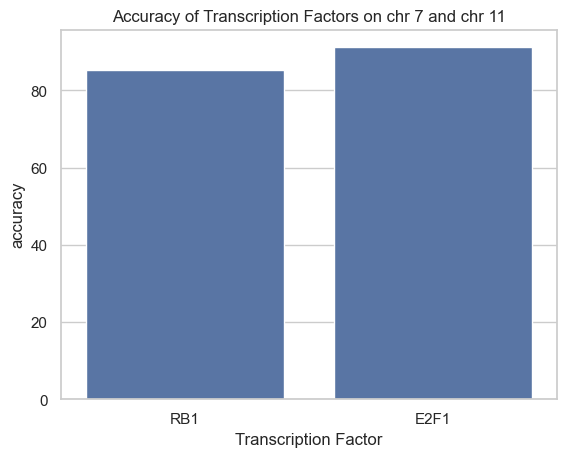

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


data = {
    'Transcription Factor': ["RB1", "E2F1"],
    'accuracy': [85.2941, 91.1713],
}


# craete bar plot with the title "Accuracy of Transcription Factors on chr 7 and chr 11"
df = pd.DataFrame(data)


sns.set(style="whitegrid")
ax = sns.barplot(x="Transcription Factor", y="accuracy", data=df)
ax.set_title("Accuracy of Transcription Factors on chr 7 and chr 11")
plt.show()

In [2]:
import boto3
import os

from sagemaker import get_execution_role, Session

# Initialize a SageMaker session
sagemaker_session = Session()



role = "arn:aws:iam::016114370410:role/tf-binding-sites"
#s3://tf-binding-sites/inference/output/RB1Model-on-E2F1-2024-09-18-16-34-52/
# prefix = "inference/output/AR-22Rv1-greater-2024-08-09-10-18-34/"
prefix = "inference/output/RB1Model-on-E2F1-2024-09-18-16-34-52/"

local_dir = "/Users/wejarrard/projects/tf-binding/data/jsonl_output"


# Initialize the S3 client
s3 = boto3.client('s3')

# Specify your S3 bucket name
bucket_name = sagemaker_session.default_bucket()


# Function to download files from an S3 bucket
def download_from_s3(bucket_name, prefix, local_dir):
    if not os.path.exists(local_dir):
        os.makedirs(local_dir)

    # List objects within the specified prefix
    response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

    # Iterate over each object
    for obj in response.get('Contents', []):
        key = obj['Key']
        # Skip if it's a folder
        if key.endswith('/'):
            continue
        local_path = os.path.join(local_dir, os.path.basename(key))
        
        # Download the file
        s3.download_file(bucket_name, key, local_path)
        print(f'Downloaded {key} to {local_path}')

# Bucket name extracted from the S3 URI
bucket_name = "tf-binding-sites"

# delete the files in local dir
for file in os.listdir(local_dir):
    os.remove(os.path.join(local_dir, file))
    

# Download the files
download_from_s3(bucket_name, prefix, "/Users/wejarrard/projects/tf-binding/data/jsonl_output")

sagemaker.config INFO - Not applying SDK defaults from location: /Library/Application Support/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/wejarrard/Library/Application Support/sagemaker/config.yaml
Downloaded inference/output/RB1Model-on-E2F1-2024-09-18-16-34-52/dataset_1.jsonl.gz.out to /Users/wejarrard/projects/tf-binding/data/jsonl_output/dataset_1.jsonl.gz.out
Downloaded inference/output/RB1Model-on-E2F1-2024-09-18-16-34-52/dataset_10.jsonl.gz.out to /Users/wejarrard/projects/tf-binding/data/jsonl_output/dataset_10.jsonl.gz.out
Downloaded inference/output/RB1Model-on-E2F1-2024-09-18-16-34-52/dataset_11.jsonl.gz.out to /Users/wejarrard/projects/tf-binding/data/jsonl_output/dataset_11.jsonl.gz.out
Downloaded inference/output/RB1Model-on-E2F1-2024-09-18-16-34-52/dataset_12.jsonl.gz.out to /Users/wejarrard/projects/tf-binding/data/jsonl_output/dataset_12.jsonl.gz.out
Downloaded inference/output/RB1Model-on-E2F1-2024-09-18-16-34-52/datas

In [3]:
import pandas as pd
import glob
import matplotlib.pyplot as plt


# Path to the directory containing JSON files
json_dir = "/Users/wejarrard/projects/tf-binding/data/jsonl_output"

# Get a list of all JSON files in the directory
json_files = glob.glob(f"{json_dir}/*.jsonl.gz.out")

# Read each JSON file into a DataFrame and store in a list
dataframes = [pd.read_json(file) for file in json_files]

# Concatenate all DataFrames into a single DataFrame
df = pd.concat(dataframes, ignore_index=True)

df

,chr_name,start,end,cell_line,targets,predicted,weights,probabilities,enhancer,promoter
0,chr11,66950196,66950369,MDA-MB-231,1,1,1,0.951382,0,0
1,chr11,124754389,124754665,MDA-MB-231,1,1,1,0.850898,0,0
2,chr11,118938599,118938878,MDA-MB-231,1,0,1,0.453542,0,0
3,chr7,7968377,7969008,MDA-MB-231,1,1,1,0.984729,0,0
4,chr11,94767993,94768605,MDA-MB-231,1,1,1,0.993861,0,0
...,...,...,...,...,...,...,...,...,...,...
14871,chr7,139437667,139438042,MCF7,0,0,0,0.000967,0,0
14872,chr11,78019812,78020753,MCF7,0,0,0,0.006968,0,0
14873,chr11,7573667,7574057,MCF7,0,0,0,0.020502,0,0
14874,chr11,134639756,134640475,MCF7,0,0,0,0.360120,0,0


In [4]:
# get accuracy
# get dataframe of false positives
df['tp'] = (df['targets'] == 1) & (df['predicted'] == 1)
df['fp'] = (df['targets'] == 0) & (df['predicted'] == 1)
df['fn'] = (df['targets'] == 1) & (df['predicted'] == 0)
df['tn'] = (df['targets'] == 0) & (df['predicted'] == 0)

df['tp'].sum(), df['fp'].sum(), df['fn'].sum(), df['tn'].sum()

accuracy = (df['tp'].sum() + df['tn'].sum()) / df.shape[0]

accuracy

0.7780989513310029